<a href="https://colab.research.google.com/github/Plashka320/Stat_prack_HW_VyuzhaninPD_2025/blob/main/HW_3_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Serial test

Idea: break the sequence $x_1, x_2, x_3, ..., x_{2n}$ into consecutive series of length $2$: $(x_1, x_2), (x_3, x_4), ..., (x_{2n-1}, x_{2n})$ and look at each element as a random and independent point in $2D$ space. Next, apply chi-square. Similarly, one can construct series of length $3, 4$, etc.

### Problem 1
Implement serial test and apply to a `samples`

Chi-square Statistic: 114.39999999999999
P-value: 0.1380441495447643


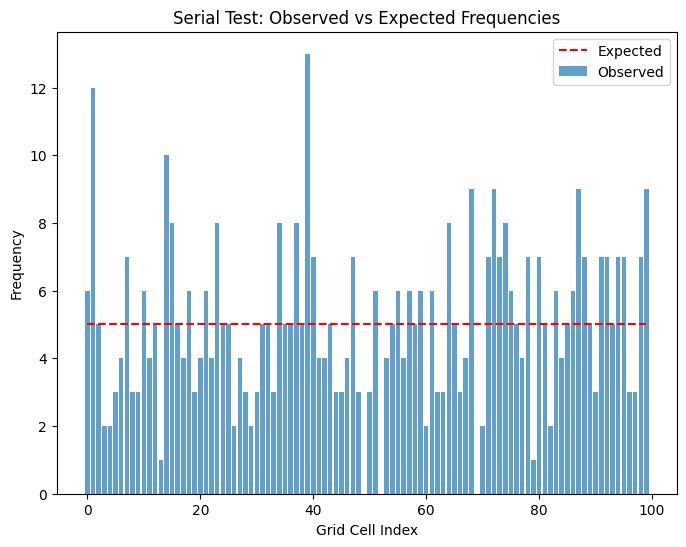

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare

def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1
samples = [rng() for _ in range(1000)]

def serial_test(samples, k=10, d=2):
    """
    k: number of bins per dimension (grid size)
    d: dimension (e.g., 2 for pairs, 3 for triplets)
    """
    samples = np.array(samples)
    n = len(samples) // d
    points = samples[:n * d].reshape(n, d)
    bins = np.linspace(0, 1, k + 1)
    hist, _ = np.histogramdd(points, bins=[bins] * d)
    f_obs = hist.flatten()
    expected_count = n / (k ** d)
    f_exp = np.full(f_obs.shape, expected_count)

    chi2_stat, p_value = chisquare(f_obs, f_exp)
    return chi2_stat, p_value, f_obs, f_exp

chi2_stat, p_value, f_obs, f_exp = serial_test(samples, k=10, d=2)

print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")

plt.figure(figsize=(8, 6))
plt.bar(range(len(f_obs)), f_obs, alpha=0.7, label="Observed")
plt.plot(range(len(f_exp)), f_exp, "r--", label="Expected")
plt.xlabel("Grid Cell Index")
plt.ylabel("Frequency")
plt.title("Serial Test: Observed vs Expected Frequencies")
plt.legend()
plt.show()


### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

In [ ]:
# Your code here

### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [ ]:
import numpy as np
from scipy.stats import chi2

def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1
random_bad = [rng_bad() for _ in range(30000)]

rng_good = np.random.random(30000)

def uniformity_test(data, k=10):
    bins = np.linspace(0, 1, k+1)
    hist, _ = np.histogram(data, bins)

    expected_count = len(data) / k
    chi2_stat = np.sum((hist - expected_count)**2 / expected_count)

    p_value = 1 - chi2.cdf(chi2_stat, df=k-1)

    return chi2_stat, p_value

chi2_stat_bad, p_value_bad = uniformity_test(random_bad)

chi2_stat_good, p_value_good = uniformity_test(rng_good)

print(f"Chi-squared Statistic for bad RNG: {chi2_stat_bad}")
print(f"P-value for bad RNG: {p_value_bad}")

print(f"Chi-squared Statistic for good RNG: {chi2_stat_good}")
print(f"P-value for good RNG: {p_value_good}")


Chi-squared Statistic for bad RNG: 17.656
P-value for bad RNG: 0.03938091477443251
Chi-squared Statistic for good RNG: 6.937999999999999
P-value for good RNG: 0.6435745364919514


* More randomness tests - [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).
* More methods for generating a uniform value [here](https://en.wikipedia.org/wiki/List_of_random_number_generators).
* A story about dynamical systems and the transition to chaos https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

# Generating a sample from a given distribution

Suppose we have a random number generator from the segment [0, 1] (use the `np.random.rand()` function for this). How to get a sample from another distribution $F$?

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

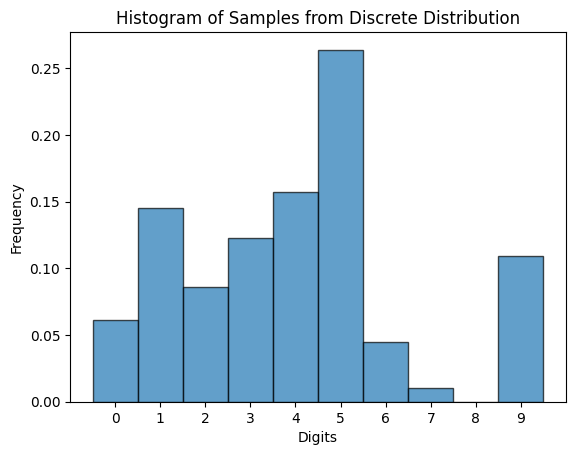

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])

normalized_weights = weights / np.sum(weights)

sorted_indices = np.argsort(normalized_weights)[::-1]
sorted_weights = normalized_weights[sorted_indices]

cdf = np.cumsum(sorted_weights)

random_samples = []
for _ in range(1000):
    rand = np.random.random()
    digit = np.searchsorted(cdf, rand)
    random_samples.append(sorted_indices[digit])

plt.hist(random_samples, bins=np.arange(11) - 0.5, density=True, edgecolor='black', alpha=0.7)
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.title('Histogram of Samples from Discrete Distribution')
plt.xticks(np.arange(10))
plt.show()


## Inverse transform method

The following proposition is the idea behind the *inverse transform* method:

If $\xi$ has a uniform distribution in $[0,1]$, then $F^{-1}(\xi)$ is distributed according to the law of $F$. (For which $F$ is this true?)

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

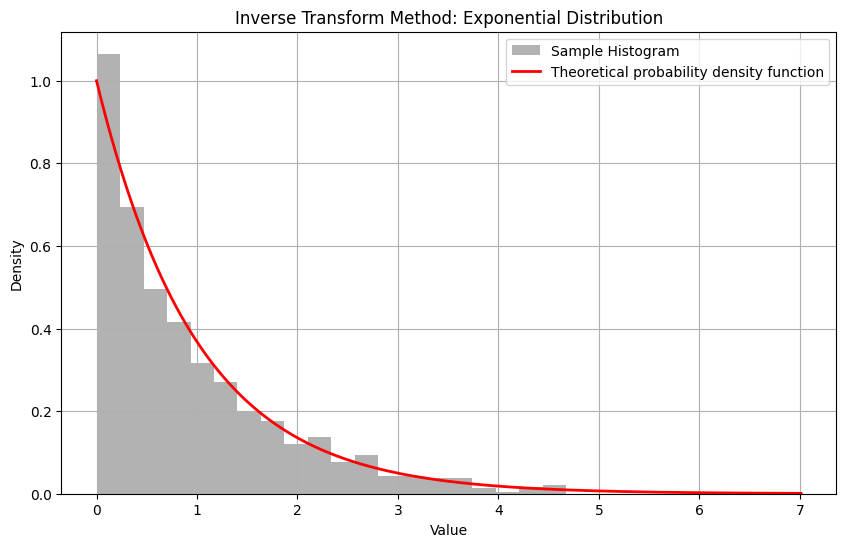

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

lambda_param = 1.0

uniform_samples = np.random.uniform(0, 1, 1000)

exponential_samples = -np.log(uniform_samples) / lambda_param

plt.figure(figsize=(10, 6))
plt.hist(exponential_samples, bins=30, density=True, alpha=0.6, color='gray', label="Sample Histogram")

x = np.linspace(0, np.max(exponential_samples), 1000)
pdf = lambda_param * np.exp(-lambda_param * x)
plt.plot(x, pdf, 'r-', lw=2, label="Theoretical probability density function")

plt.title("Inverse Transform Method: Exponential Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

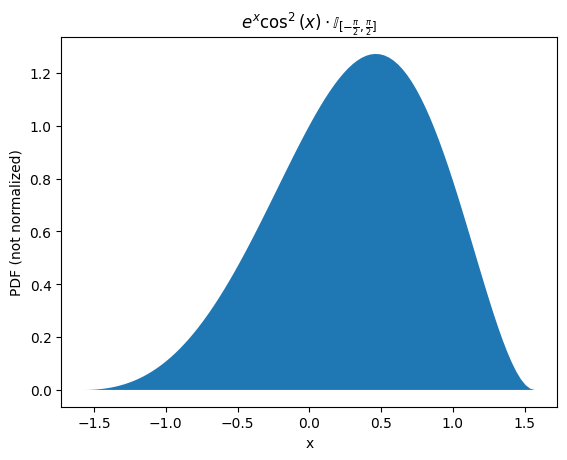

In [ ]:
fig = plt.figure()

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def density(x):
    return np.exp(x) * np.cos(x)**2

def rejection_sampling(n, density_func, a=-np.pi/2, b=np.pi/2):
    x_vals = np.linspace(a, b, 1000)
    max_density = np.max(density_func(x_vals))

    samples = []

    while len(samples) < n:
        x = np.random.uniform(a, b)
        y = np.random.uniform(0, max_density)

        if y <= density_func(x):
            samples.append(x)

    return np.array(samples)

n_samples = 1000
samples = rejection_sampling(n_samples, density)

plt.figure(figsize=(10, 6))

plt.hist(samples, bins=30, density=True, alpha=0.7, label='Sampled', color='blue')

x = np.linspace(-np.pi/2, np.pi/2, 1000)
y = density(x)
plt.plot(x, y, 'r-', label=r'$e^x \cos^2(x)$', lw=2)

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Sampling from $e^x \cos^2(x)$ using Rejection Sampling')
plt.legend()
plt.show()


## Coordinate transformation method

The accept-reject method may in some cases be inefficient and require too many sample points. An alternative is to try to find a coordinate transformation that converts a simple area (from which it is easy to sample, for example, a unit square) into the required area, but preserves the area ratio (why?).

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

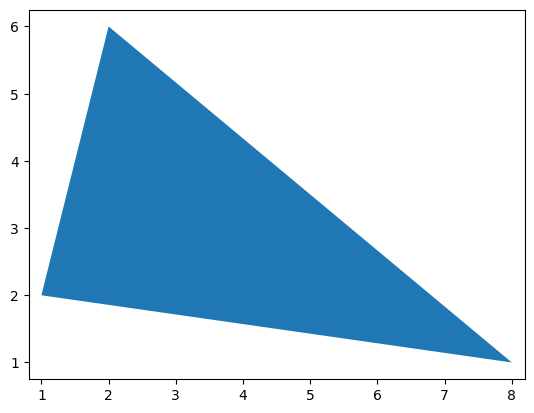

In [ ]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.axis('equal')
plt.show()

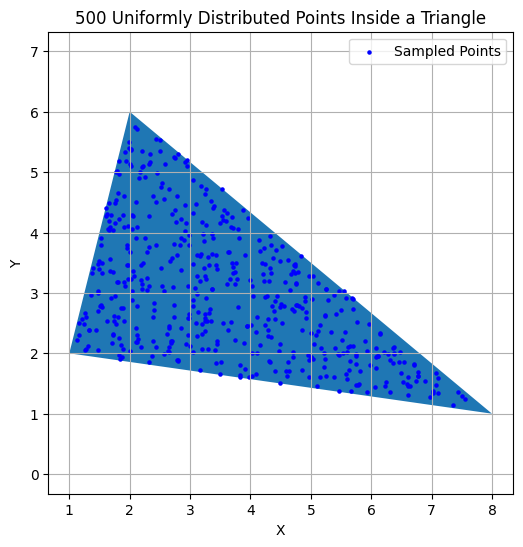

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

vertices = np.array([[1, 2], [2, 6], [8, 1]])

def cross_product_sign(p1, p2, p3):
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def is_point_in_triangle(p, vertices):
    sign1 = cross_product_sign(vertices[0], vertices[1], p)
    sign2 = cross_product_sign(vertices[1], vertices[2], p)
    sign3 = cross_product_sign(vertices[2], vertices[0], p)

    has_neg = (sign1 < 0) or (sign2 < 0) or (sign3 < 0)
    has_pos = (sign1 > 0) or (sign2 > 0) or (sign3 > 0)
    return not (has_neg and has_pos)

def generate_points_inside_triangle(num_points, vertices):
    points = []
    while len(points) < num_points:
        x = np.random.uniform(min(vertices[:, 0]), max(vertices[:, 0]))
        y = np.random.uniform(min(vertices[:, 1]), max(vertices[:, 1]))
        point = np.array([x, y])

        if is_point_in_triangle(point, vertices):
            points.append(point)

    return np.array(points)

num_points = 500
points = generate_points_inside_triangle(num_points, vertices)

fig = plt.figure(figsize=(6, 6))

polygon = Polygon(vertices, closed=True, edgecolor='black', facecolor='gray', alpha=0.3)
plt.gca().add_collection(PatchCollection([polygon]))

plt.scatter(points[:, 0], points[:, 1], color='blue', s=5, label='Sampled Points')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('500 Uniformly Distributed Points Inside a Triangle')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

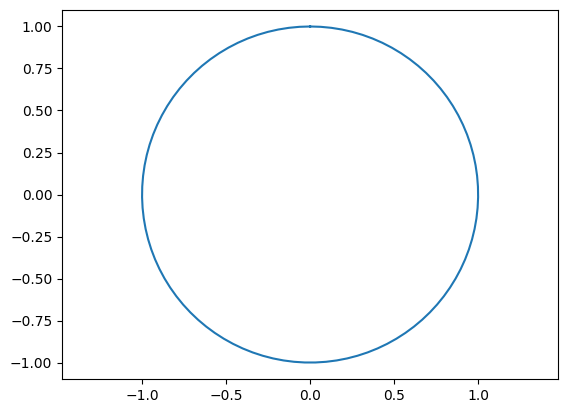

In [ ]:
fig = plt.figure()

t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

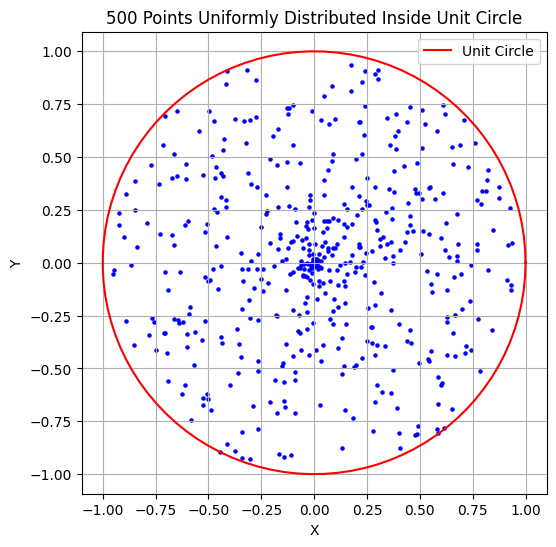

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_points_in_unit_circle(num_points):
    points = []
    for _ in range(num_points):
        r = np.sqrt(np.random.uniform(0, 1))
        theta = np.random.uniform(0, 2 * np.pi)

        x = r * np.cos(theta)
        y = r * np.sin(theta)
        points.append([x, y])

    return np.array(points)

num_points = 500
points = generate_points_in_unit_circle(num_points)

fig = plt.figure(figsize=(6, 6))

plt.scatter(points[:, 0], points[:, 1], color='blue', s=5)

theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), color='red', label='Unit Circle')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('500 Points Uniformly Distributed Inside Unit Circle')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


# Random normal generator

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

In [ ]:
import seaborn as sns

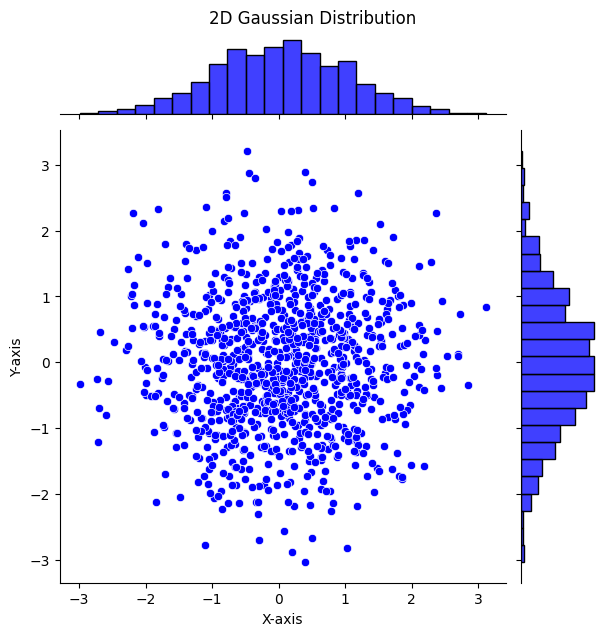

In [ ]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)


joint_plot = sns.jointplot(x=x, y=y, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

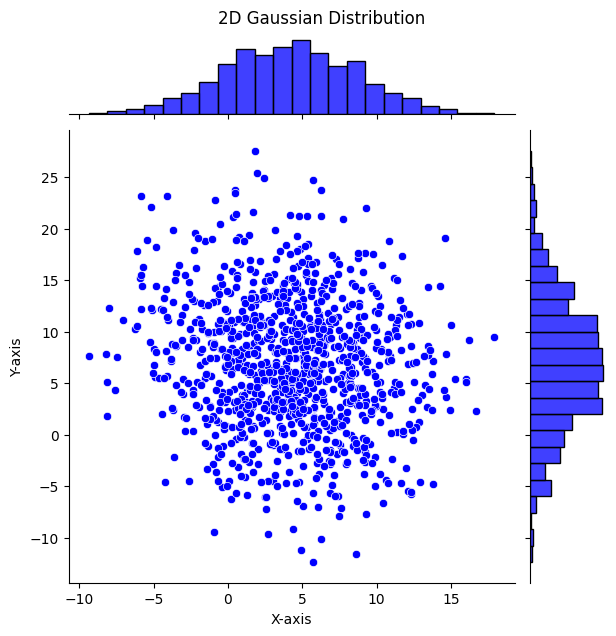

Sample Mean:
[4.14337815 6.80107533]
Sample Covariance Matrix:
[[20.84472031 -3.81887264]
 [-3.81887264 40.31839783]]
Exact Mean:
[4 7]
Exact Covariance Matrix:
[[20 -4]
 [-4 40]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

mu = np.array([4, 7])
Sigma = np.array([[20, -4], [-4, 40]])

L = np.linalg.cholesky(Sigma)

n = 1000
u1, u2 = np.random.rand(2, n)

r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
z0 = r * np.cos(theta)
z1 = r * np.sin(theta)

samples = np.dot(L, np.array([z0, z1])) + mu[:, np.newaxis]

x, y = samples

joint_plot = sns.jointplot(x=x, y=y, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

sample_mean = np.mean(samples, axis=1)
sample_cov = np.cov(samples)

print(f"Sample Mean:\n{sample_mean}")
print(f"Sample Covariance Matrix:\n{sample_cov}")
print(f"Exact Mean:\n{mu}")
print(f"Exact Covariance Matrix:\n{Sigma}")


### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [ ]:
# Your code here

# Basic distributions
- **Uniform distribution $\operatorname{U}[a, b]$**:
$$p(x) = \frac{1}{b-a}\cdot\mathbb{I}_{x\in[a, b]}$$

- **Exponential distribution $\operatorname{Exp}(\lambda)$**:
$$p(x) = \lambda e^{-\lambda x}\cdot\mathbb{I}_{x\geqslant0}$$

- **Normal distribution $\mathcal{N}(\mu, \sigma^2)$**:
$$p(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

- **Gamma distribution $\operatorname{Gamma}(\alpha, \lambda)$**:
$$p(x) = \frac{\lambda^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\lambda x}\cdot\mathbb{I}_{x\geqslant0}$$

- **Beta distribution $\operatorname{Beta}(\alpha, \beta)$**:
$$p(x) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}x^{\alpha-1}(1-x)^{\beta-1}\cdot\mathbb{I}_{x\in[0, 1]}$$

- **$\chi^2$ distribution with $k$ degrees of freedom $\chi^2(k)$**:
$$p(x) = \frac{1}{2^{k/2}\Gamma(k/2)}x^{k/2-1}e^{-x/2}\cdot\mathbb{I}_{x\geqslant0}$$



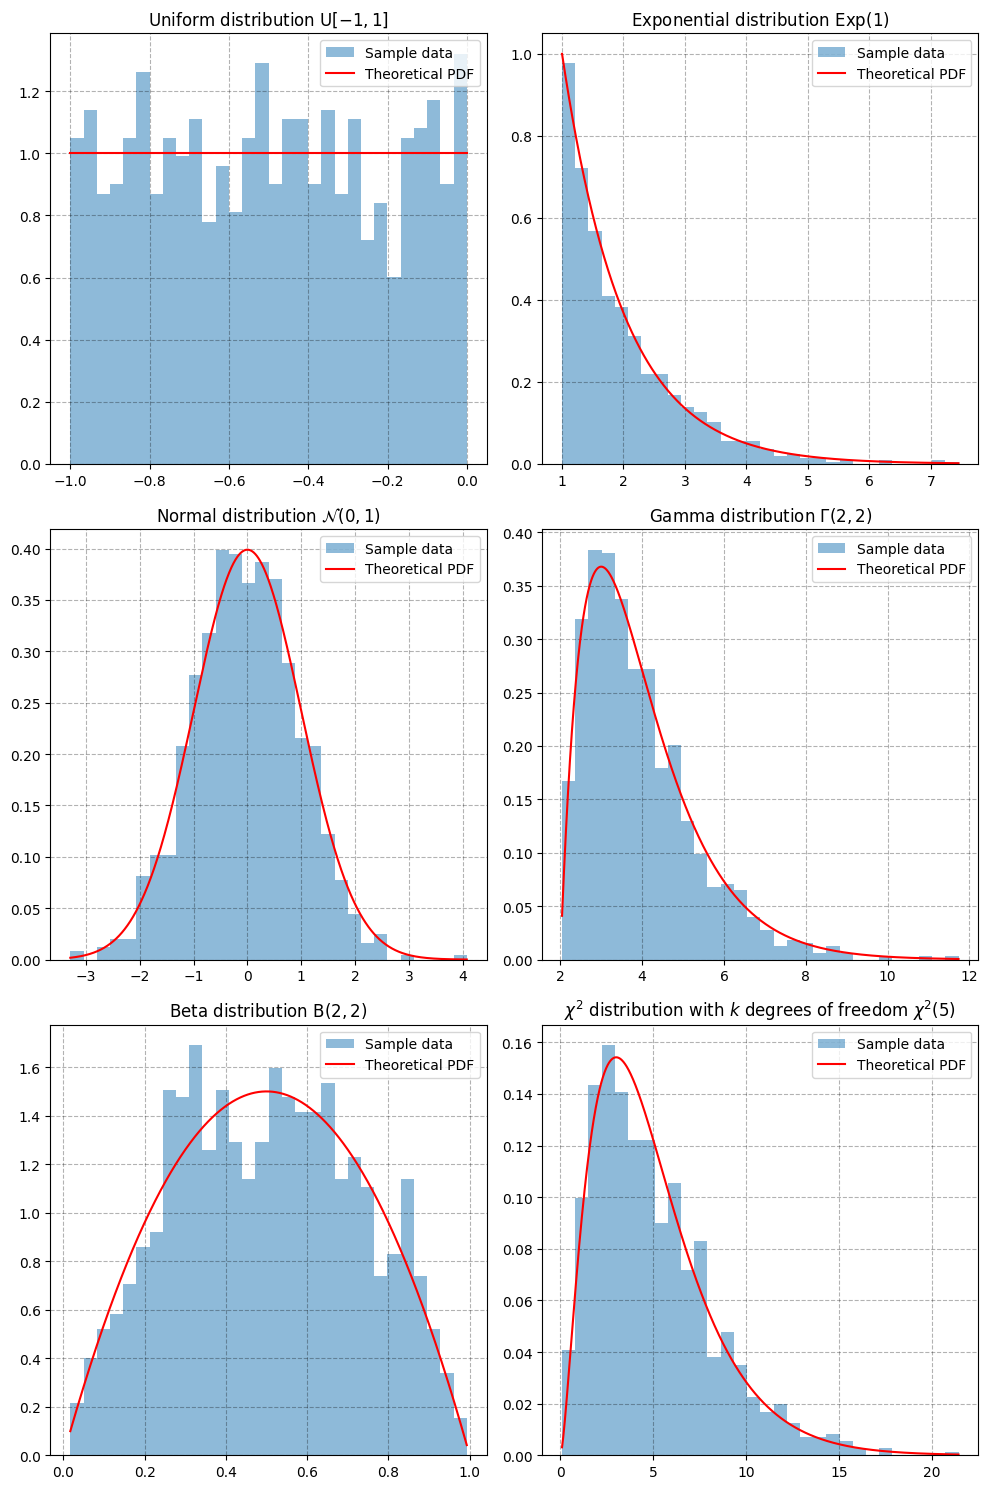

In [ ]:
# Define distributions and their parameters
distributions = [
    ("Uniform distribution $\\operatorname{U}[-1, 1]$", stats.uniform, (-1, 1)),
    ("Exponential distribution $\\operatorname{Exp}(1)$", stats.expon, (1,)),
    ("Normal distribution $\\mathcal{N}(0, 1)$", stats.norm, (0, 1)),
    ("Gamma distribution $\\Gamma(2, 2)$", stats.gamma, (2, 2)),
    ("Beta distribution $\\operatorname{B}(2, 2)$", stats.beta, (2, 2)),
    ("$\\chi^2$ distribution with $k$ degrees of freedom $\\chi^2(5)$", stats.chi2, (5,))
]

# Setup the figure and axes for a 2x3 subplot
fig, axs = plt.subplots(3, 2, figsize=(10, 15))  # Adjust figsize according to your needs
axs = axs.flatten()  # Flatten the array to easily iterate over it

for ax, (name, dist, params) in zip(axs, distributions):
    # Generate sample data
    data = dist.rvs(*params, size=1000)
    # Generate points for PDF
    x = np.linspace(min(data), max(data), 1000)
    pdf = dist.pdf(x, *params)

    # Plot histogram of sample data
    ax.hist(data, bins=30, density=True, alpha=0.5, label='Sample data')
    # Plot theoretical PDF
    ax.plot(x, pdf, 'r-', label='Theoretical PDF')
    ax.set_title(name)
    ax.legend()
    ax.grid(linestyle='--', color='black', alpha=0.3)

plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()
